# Project 3: Capital Bikeshare

## Objective

You are provided with hourly bike rental data for the __first 19 days of each month__.
Your task is to design and tune a machine learning regression model to __predict the demand for bike in the rest
of the days of the months__.

## The Challenge

1. Data Wrangling & Cleaning
2. Exploratory Data Analysis
3. Feature Engineering (including polynomial feature expansion)
4. Train-Validation-Split
5. Train the model
6. Validate the model (calculate the RMSLE for the training als well as the validation set)
7. Run your model on the test set and upload your results to Kaggle

Bonus: Regularize the model and test how you can avoid overfitting with it.

## Preparations

In [1]:
# Importing usual Data Science toolkit

import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression

# Some custom settings

# Setting float precision to 2 decimal places (for display)
pd.options.display.float_format = '{:,.2f}'.format

## Data Acquisition

Data is available in subdirectory `data/`:

  * `train.csv` - Train data
  * `test.csv`  - Test data

In [2]:
# Reading train and test data, with parsed 'datetime' as index
df_train = pd.read_csv('data/train.csv', index_col='datetime', parse_dates=True)
df_test = pd.read_csv('data/test.csv', index_col='datetime', parse_dates=True)

In [3]:
df_train

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
2012-12-19 19:00:00,4,0,1,1,15.58,19.70,50,26.00,7,329,336
2012-12-19 20:00:00,4,0,1,1,14.76,17.43,57,15.00,10,231,241
2012-12-19 21:00:00,4,0,1,1,13.94,15.91,61,15.00,4,164,168


### Data fields

  * __datetime__: hourly date + timestamp  
  * __season__:
      * 1: spring
      * 2: summer
      * 3: fall
      * 4: winter 
  * __holiday__: whether the day is considered a holiday
  * __workingday__: whether the day is neither a weekend nor holiday
  * __weather__:
      * 1: Clear, Few clouds, Partly cloudy, Partly cloudy
      * 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
      * 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
      * 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog 
  * __temp__: temperature in Celsius
  * __atemp__: "feels like" temperature in Celsius
  * __humidity__: relative humidity
  * __windspeed__: wind speed
  * __casual__: number of non-registered user rentals initiated
  * __registered__: number of registered user rentals initiated
  * __count__: number of total rentals
  
The model is supposed to predict:
  * __causal__
  * __registered__
  * __count__

## Data wrangling and cleaning

### Data plausibility check

#### Checking for NaNs

In [4]:
print(f"Empty cells in train dataset: {df_train.isna().sum().sum()}")
print(f"Empty cells in test dataset: {df_test.isna().sum().sum()}")

Empty cells in train dataset: 0
Empty cells in test dataset: 0


There is no missing data in both sets.

#### Checking dtypes

In [5]:
print("Training set info():")
df_train.info()
print()
print("Testing set info():")
df_test.info()

Training set info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 11 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
dtypes: float64(3), int64(8)
memory usage: 1020.6 KB

Testing set info():
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6493 entries, 2011-01-20 00:00:00 to 2012-12-31 23:00:00
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0  

All provided features are _numeric_ (`float64` or `int64`).

#### Checking values plausibility

First look at basic descriptive statistics about both series:

In [6]:
df_train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,"10,886.00","10,886.00","10,886.00","10,886.00","10,886.00","10,886.00","10,886.00","10,886.00","10,886.00","10,886.00","10,886.00"
mean,2.51,0.03,0.68,1.42,20.23,23.66,61.89,12.80,36.02,155.55,191.57
std,1.12,0.17,0.47,0.63,7.79,8.47,19.25,8.16,49.96,151.04,181.14
min,1.00,0.00,0.00,1.00,0.82,0.76,0.00,0.00,0.00,0.00,1.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,47.00,7.00,4.00,36.00,42.00
50%,3.00,0.00,1.00,1.00,20.50,24.24,62.00,13.00,17.00,118.00,145.00
75%,4.00,0.00,1.00,2.00,26.24,31.06,77.00,17.00,49.00,222.00,284.00
max,4.00,1.00,1.00,4.00,41.00,45.45,100.00,57.00,367.00,886.00,977.00


In [7]:
df_test.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
count,"6,493.00","6,493.00","6,493.00","6,493.00","6,493.00","6,493.00","6,493.00","6,493.00"
mean,2.49,0.03,0.69,1.44,20.62,24.01,64.13,12.63
std,1.09,0.17,0.46,0.65,8.06,8.78,19.29,8.25
min,1.00,0.00,0.00,1.00,0.82,0.00,16.00,0.00
25%,2.00,0.00,0.00,1.00,13.94,16.66,49.00,7.00
50%,3.00,0.00,1.00,1.00,21.32,25.00,65.00,11.00
75%,3.00,0.00,1.00,2.00,27.06,31.06,81.00,17.00
max,4.00,1.00,1.00,4.00,40.18,50.00,100.00,56.00


__Results__:
  * __season__ is in interval $<1, 4>$ &#9989;
  * __holiday__ is in interval $<0, 1>$ &#9989;
  * __workingday__ is in interval $<0, 1>$ &#9989;
  * __weather__ is in interval $<1, 4>$ &#9989;
  * __temp__ is in interval $<0.82, 41>$ with means of the respective sets in $\{20.23, 20.62\}$ &#9989;
  * __atemp__ is in interval $<0, 50>$ with means of the respective sets in $\{23.66, 24.01\}$ &#9989;
  * __humidity__ is in interval $<0, 100>$ &#9989;
  * __windspeed__ is in interval $<0, 57>$ with means of the respective sets in $\{8.16, 8.25\}$ &#9989;
  
__Note__:

  * __temp__ is normalized temperature in Celsius. The values are derived via:  
  $t_{norm}=\frac{t-t_{min}}{t_{max}-t_{min}}$  
  $t_{min}=-8$  
  $t_{max}=+39$  

  * __atemp__ is normalized _"apparent temperature"_ in Celsius. The values are derived via:  
  $t_{norm}=\frac{t-t_{min}}{t_{max}-t_{min}}$  
  $t_{min}=-16$  
  $t_{max}=+50$

  * __humidity__ is normalized humidity. The values are divided to 100 (max).
  * __windspeed__ is normalized wind speed. The values are divided to 67 (max).
  
The normalization is not an issue. It has no effect on any modeling effectiveness, merely making human interpretation of the feature values more difficult.

**Source**: UCI ML (where the original dataset is hosted): https://archive.ics.uci.edu/ml/datasets/Bike+Sharing+Dataset

## Exploratory data analysis

### Casual users over time

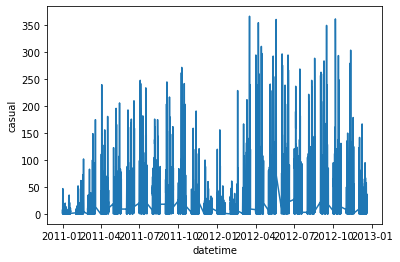

In [8]:
sns.lineplot(x="datetime", y="casual", data=df_train)
plt.show()

### Regirstered users over time

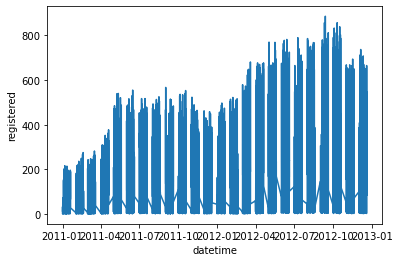

In [9]:
sns.lineplot(x="datetime", y="registered", data=df_train)
plt.show()

### Understanding correlation between _casual_ and _registered_ users

Following plot shows that there is some correlation between these two variables:

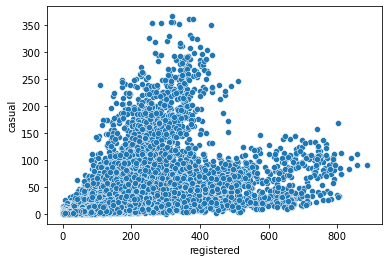

In [10]:
sns.scatterplot(x="registered", y="casual", data=df_train)
plt.show()

Existence of the two separate "branches" suggests there's another variable in play, which affects the correlation strength. The intuition leads to ingest _workingday_ into the overview, which clearly sets these apart:

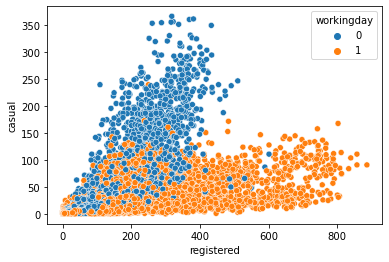

In [11]:
sns.scatterplot(x="registered", y="casual", hue="workingday", data=df_train)
plt.show()

**Observation**: There's interesting change in correlation between _casual_ and _registered_ users given it's _working day_ or not.

### Correlation matrix

            season  holiday  workingday  weather  temp  atemp  humidity  \
season        1.00     0.03       -0.01     0.01  0.26   0.26      0.19   
holiday       0.03     1.00       -0.25    -0.01  0.00  -0.01      0.00   
workingday   -0.01    -0.25        1.00     0.03  0.03   0.02     -0.01   
weather       0.01    -0.01        0.03     1.00 -0.06  -0.06      0.41   
temp          0.26     0.00        0.03    -0.06  1.00   0.98     -0.06   
atemp         0.26    -0.01        0.02    -0.06  0.98   1.00     -0.04   
humidity      0.19     0.00       -0.01     0.41 -0.06  -0.04      1.00   
windspeed    -0.15     0.01        0.01     0.01 -0.02  -0.06     -0.32   
casual        0.10     0.04       -0.32    -0.14  0.47   0.46     -0.35   
registered    0.16    -0.02        0.12    -0.11  0.32   0.31     -0.27   
count         0.16    -0.01        0.01    -0.13  0.39   0.39     -0.32   

            windspeed  casual  registered  count  
season          -0.15    0.10        0.16   0.16

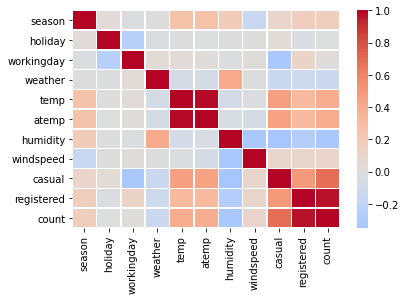

In [12]:
corr=df_train.corr()

print(corr)

sns.heatmap(data=corr, cmap="coolwarm", center=0.0, linewidths=.5)
plt.show()

## Feature engineering

### Creating data features from the date

Following cells essentially break up date index into columns:
  * year
  * month
  * day
  * hour
  
These are numerical features, so further encoding is not necessary.

In [13]:
df_train["year"] = df_train.index.year
df_train["month"] = df_train.index.month
df_train["day"] = df_train.index.day
df_train["hour"] = df_train.index.hour

df_test["year"] = df_test.index.year
df_test["month"] = df_test.index.month
df_test["day"] = df_test.index.day
df_test["hour"] = df_test.index.hour

In [14]:
print("Training set head():")
print(df_train[["year", "month", "day", "hour"]].head())

print()
print("Testing set tail():")
print(df_test[["year", "month", "day", "hour"]].tail())

Training set head():
                     year  month  day  hour
datetime                                   
2011-01-01 00:00:00  2011      1    1     0
2011-01-01 01:00:00  2011      1    1     1
2011-01-01 02:00:00  2011      1    1     2
2011-01-01 03:00:00  2011      1    1     3
2011-01-01 04:00:00  2011      1    1     4

Testing set tail():
                     year  month  day  hour
datetime                                   
2012-12-31 19:00:00  2012     12   31    19
2012-12-31 20:00:00  2012     12   31    20
2012-12-31 21:00:00  2012     12   31    21
2012-12-31 22:00:00  2012     12   31    22
2012-12-31 23:00:00  2012     12   31    23


In [15]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10886 entries, 2011-01-01 00:00:00 to 2012-12-19 23:00:00
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      10886 non-null  int64  
 1   holiday     10886 non-null  int64  
 2   workingday  10886 non-null  int64  
 3   weather     10886 non-null  int64  
 4   temp        10886 non-null  float64
 5   atemp       10886 non-null  float64
 6   humidity    10886 non-null  int64  
 7   windspeed   10886 non-null  float64
 8   casual      10886 non-null  int64  
 9   registered  10886 non-null  int64  
 10  count       10886 non-null  int64  
 11  year        10886 non-null  int64  
 12  month       10886 non-null  int64  
 13  day         10886 non-null  int64  
 14  hour        10886 non-null  int64  
dtypes: float64(3), int64(12)
memory usage: 1.3 MB


Total count of users is a composite sum of following labels:
  * _casual_
  * _registered_
  
However, the two are somewhat correlated (r = 0.50), but independent. Therefore the best approach would be to create separate models predicting values for each.

These labels will not be used as explanatory features for each other. Therefore it is necessary to prepare two separate label arrays for them.


In [16]:
# Feature dataframes
X_train = df_train.loc[:, ~df_train.columns.isin(["casual", "registered", "count"])]
X_test = df_test.loc[:, ~df_test.columns.isin(["casual", "registered", "count"])]

# yc_train = target (casual)
yc_train = df_train["casual"]

# yr_train = target (registered)
yr_train = df_train["registered"]

## Model training

### Least Squares Linear Regression Model

In [17]:
# Training linear regression for yc_train (casual) label
lsqm_casual = LinearRegression().fit(X_train, yc_train)
lsqm_registered = LinearRegression().fit(X_train, yr_train)

Storing prediction results into `df_result` DataFrame

In [27]:
# Making a copy of the training set (for plotting)
df_train_plot = df_train[["casual", "registered", "count"]].copy()

In [30]:
# Adding predicted columns to testing set
df_test["lsqm_casual"] = lsqm_casual.predict(X_test)
df_test["lsqm_registered"] = lsqm_registered.predict(X_test)

# Making a copy of the testing set (for plotting)
df_test_plot = df_test[["lsqm_casual", "lsqm_registered"]].copy()


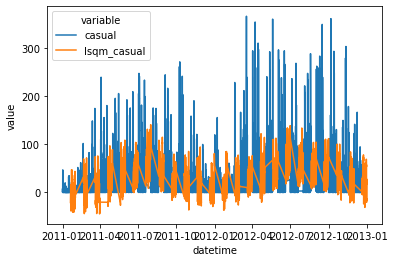

In [43]:
df_result_plot = pd.merge(df_train_plot, df_test_plot, how="outer", on="datetime" )

dt = df_result_plot[["casual","lsqm_casual"]].melt(ignore_index=False)

sns.lineplot(x="datetime", y="value", hue="variable", data=dt)
plt.show()

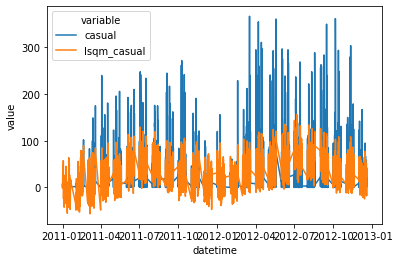

In [22]:
df_result[["casual", "lsqm_casual"]]
dt = df_result[["casual", "lsqm_casual"]].melt(value_vars=["casual", "lsqm_casual"], ignore_index=False)

sns.lineplot(x="datetime", y="value", hue="variable", data=dt)
plt.show()

#sns.lineplot(x="datetime", y="casual", data=df_result[["casual", "casual_lsqm"]])


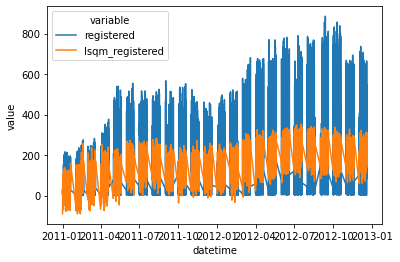

In [23]:
dt = df_result[["registered", "lsqm_registered"]].melt(value_vars=["registered", "lsqm_registered"], ignore_index=False)

sns.lineplot(x="datetime", y="value", hue="variable", data=dt)
plt.show()

In [24]:
# Predicting for testing set:

test_df = lsqm_casual.predict(X_test)

In [26]:
X_test
#test_df

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,year,month,day,hour
datetime,,,,,,,,,,,,
2011-01-20 00:00:00,1,0,1,1,10.66,11.37,56,26.00,2011,1,20,0
2011-01-20 01:00:00,1,0,1,1,10.66,13.63,56,0.00,2011,1,20,1
2011-01-20 02:00:00,1,0,1,1,10.66,13.63,56,0.00,2011,1,20,2
2011-01-20 03:00:00,1,0,1,1,10.66,12.88,56,11.00,2011,1,20,3
2011-01-20 04:00:00,1,0,1,1,10.66,12.88,56,11.00,2011,1,20,4
...,...,...,...,...,...,...,...,...,...,...,...,...
2012-12-31 19:00:00,1,0,1,2,10.66,12.88,60,11.00,2012,12,31,19
2012-12-31 20:00:00,1,0,1,2,10.66,12.88,60,11.00,2012,12,31,20
2012-12-31 21:00:00,1,0,1,1,10.66,12.88,60,11.00,2012,12,31,21
